<a href="https://colab.research.google.com/github/msamunetogetoge/masamune/blob/master/make_neuralnet_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# python によるニューラルネットワークの実装1 のコード

fashon mnist を自前のニューラルネットワークで学習しようという記事です。
一回目はモデルを作るだけです。二回目以降で学習出来るようにします。

In [0]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [0]:
fashion_mnist = keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

In [0]:
train_images = train_images / 255.0
test_images = test_images / 255.0
train_images = train_images.flatten().reshape(-1,784)
test_images = test_images.flatten().reshape(-1,784)

In [0]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

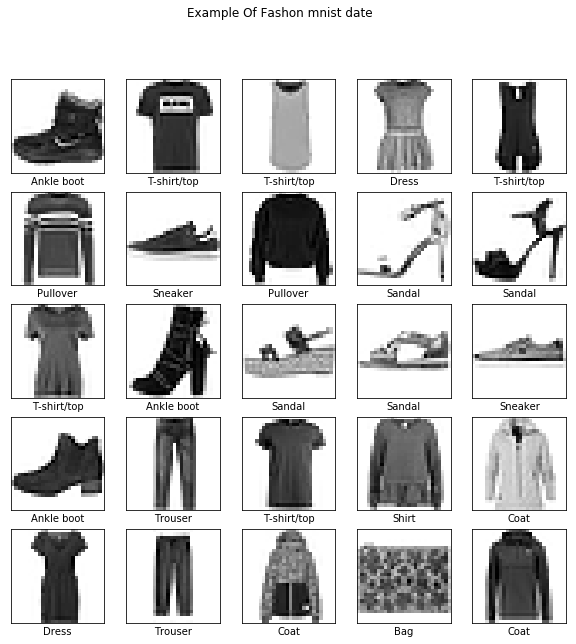

In [0]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])
plt.suptitle("Example Of Fashon mnist date"  )
plt.savefig("fashon_mnist.png")
plt.show()

活性化関数とsoftmax関数も自前で用意します。

In [0]:
def relu(x):
    return np.maximum(0, x)

def softmax(x):
    if x.ndim == 2:
        x = x.T
        x = x - np.max(x, axis=0)
        y = np.exp(x) / np.sum(np.exp(x), axis=0)
        return y.T 

    x = x - np.max(x) # オーバーフロー対策
    return np.exp(x) / np.sum(np.exp(x))

入力、出力含めて3層からなるニューラルネットワークです。

In [0]:
class TwoLayerNet:

    def __init__(self, input_size, hidden_size, output_size, weight_init_std=0.01):
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)

    def predict(self, x):
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']
    
        a1 = np.dot(x, W1) + b1
        z1 = relu(a1)
        a2 = np.dot(z1, W2) + b2
        y = softmax(a2)
        
        return y
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy

In [0]:
network=TwoLayerNet(input_size=len(train_images[0].flatten()),hidden_size=64, output_size=10)

何も訓練していませんが、動くかだけ確認です。

In [0]:
T=network.predict(train_images[:10].flatten().reshape(-1,784))
np.argmax(T,axis=1)

array([5, 2, 8, 8, 8, 3, 1, 8, 8, 5], dtype=int64)

ランダムに回答を得ているので、良い所10%が正解率ですが、見てみます。

In [0]:
network.accuracy(train_images , train_labels )

0.05976666666666667

# python によるニューラルネットワークの実装2のコード

損失関数を定義するのと、微分を計算出来るようにして、学習するための準備をします。

In [0]:
def relu_grad(x):
    grad = np.zeros(x.size).reshape(x.shape)
    grad[x>=0] = 1
    
    return grad
def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
        
    # 教師データがone-hot-vectorの場合、正解ラベルのインデックスに変換
    if t.size == y.size:
        t = t.argmax(axis=1)
   
    return -np.sum(np.log(y[np.arange(y.shape[0]), t] + 1e-7)) / y.shape[0]

取りあえず動くか確認です。

In [0]:
network=TwoLayerNet(input_size=len(train_images[0]),hidden_size=64, output_size=10)
y=network.predict(train_images[:10])
t=train_labels[:10]
cross_entropy_error(y,t)

2.305356509113412

微分と損失関数の計算を実装したニューラルネットワークの定義です。

In [0]:
class TwoLayerNet:

    def __init__(self, input_size, hidden_size, output_size, weight_init_std=0.01):
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)

    def predict(self, x):
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']
    
        a1 = np.dot(x, W1) + b1
        z1 = relu(a1)
        a2 = np.dot(z1, W2) + b2
        y = softmax(a2)
        
        return y
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy
    def gradient(self, x, t):
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']
        grads = {}
        
        
        #  予測値の計算 (predict と同じ )
        a1 = np.dot(x, W1) + b1
        z1 = relu(a1)
        a2 = np.dot(z1, W2) +b2
        y = softmax(a2)
        
        # 各ノードでの微分の計算。出力側から順々に計算する 
        batch_num = y.shape[0]
        dy = (y - t )/ batch_num
        grads['W2'] = np.dot(z1.T, dy)
        grads['b2'] = np.sum(dy,axis=0)
        
        dz1 = np.dot(dy, W2.T)
        da1 = relu_grad(a1) * dz1
        grads['W1'] = np.dot(x.T, da1)
        grads['b1'] = np.sum(da1,axis=0)
        ''' データ一つだけ計算したいとき用
        dy = y - t 
        grads['W2'] = np.dot(z1.reshape(-1,1), dy.reshape(1,-1))
        grads['b2'] = dy
        
        dz1 = np.dot(dy, W2.T)
        da1 = relu_grad(a1) * dz1
        grads['W1'] = np.dot(x.reshape(-1,1), da1.reshape(1,-1))
        grads['b1'] = da1
        '''
        return grads

In [0]:
network=TwoLayerNet(input_size=784,hidden_size=64, output_size=10)
gr=network.gradient(train_images, train_labels_oh)

勾配が計算出来ているか確認です。2層目のバイアス(b2)は10次元のベクトルのはずなので、見てみます。

In [0]:
gr["b2"]

array([-3.27434906e-04, -5.18489021e-04,  3.19628372e-04, -4.28169503e-04,
       -1.41978688e-04,  4.74840597e-04,  3.39473728e-04, -4.66359441e-04,
        6.61851799e-04,  8.66370631e-05])

# python によるニューラルネットワークの実装3のコード

optimizer を決めてトレーニングします。あまり良い精度にはなりません。

In [1]:
import tensorflow as tf
from tensorflow import keras

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
import seaborn as sns
sns.set()

In [0]:
def relu(x):
    return np.maximum(0, x)

def relu_grad(x):
    grad = np.zeros(x.size).reshape(x.shape)
    grad[x>=0] = 1
    
    return grad

def softmax(x):
    if x.ndim == 2:
        x = x.T
        x = x - np.max(x, axis=0)
        y = np.exp(x) / np.sum(np.exp(x), axis=0)
        return y.T 

    x = x - np.max(x) # オーバーフロー対策
    return np.exp(x) / np.sum(np.exp(x))

def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
        
    # 教師データがone-hot-vectorの場合、正解ラベルのインデックスに変換
    if t.size == y.size:
        t = t.argmax(axis=1)
   
    return -np.sum(np.log(y[np.arange(y.shape[0]), t] + 1e-7)) / y.shape[0]

In [4]:
fashion_mnist = keras.datasets.fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


In [0]:
train_images = train_images / 255.0

test_images = test_images / 255.0
train_images = train_images.flatten().reshape(-1,784)
test_images = test_images.flatten().reshape(-1,784)

In [6]:
ohe = OneHotEncoder( sparse=False)
train_labels = ohe.fit_transform(train_labels.reshape(-1,1))
test_labels = ohe.fit_transform(test_labels.reshape(-1,1))

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a Lab

In [0]:
class TwoLayerNet:

    def __init__(self, input_size, hidden_size, output_size, weight_init_std=0.01):
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)

    def predict(self, x):
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']
    
        a1 = np.dot(x, W1) + b1
        z1 = relu(a1)
        a2 = np.dot(z1, W2) + b2
        y = softmax(a2)
        
        return y
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        t = np.argmax(t, axis=1) #tをone hot encording からラベルに戻す 
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy
    def gradient(self, x, t):
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']
        grads = {}
        
        
        #  予測値の計算 (predict と同じ )
        a1 = np.dot(x, W1) + b1
        z1 = relu(a1)
        a2 = np.dot(z1, W2) +b2
        y = softmax(a2)
        
        # 各ノードでの微分の計算。出力側から順々に計算する 
        batch_num = y.shape[0]
        dy = (y - t )/ batch_num
        grads['W2'] = np.dot(z1.T, dy)
        grads['b2'] = np.sum(dy,axis=0)
        
        dz1 = np.dot(dy, W2.T)
        da1 = relu_grad(a1) * dz1
        grads['W1'] = np.dot(x.T, da1)
        grads['b1'] = np.sum(da1,axis=0)

        return grads
    
    def loss(self, x, t):
        y = self.predict(x)
        
        return cross_entropy_error(y,t)

In [8]:
network =TwoLayerNet(input_size=784, hidden_size=64 , output_size=10)
train_size = train_images.shape[0]
batch_size = 100
iter_num = 5000
learning_rate =0.1

loss_list = []
train_acc_list = []
test_acc_list = []
grad_list = []
iter_per_epoch = 100

for i in np.arange(iter_num):
    batch_mask = np.random.choice(train_size , batch_size)
    x_batch = train_images[batch_mask]
    t_batch = train_labels[batch_mask]
    grad = network.gradient(x_batch, t_batch)
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]    

    if i % iter_per_epoch == 0:
        grad_list.append(np.linalg.norm(grad["b1"]) )      
        loss = network.loss(x_batch, t_batch)
        loss_list.append(loss)
        train_acc = network.accuracy(train_images, train_labels)
        test_acc = network.accuracy(test_images, test_labels)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print("train acc, test acc | " + str(train_acc) + ", " + str(test_acc))
print("Finish Caluculation")


train acc, test acc | 0.17161666666666667, 0.174
train acc, test acc | 0.6109166666666667, 0.6066
train acc, test acc | 0.7242333333333333, 0.7118
train acc, test acc | 0.75215, 0.7407
train acc, test acc | 0.7887666666666666, 0.777
train acc, test acc | 0.8066833333333333, 0.7956
train acc, test acc | 0.81735, 0.8051
train acc, test acc | 0.8092666666666667, 0.8001
train acc, test acc | 0.82695, 0.8126
train acc, test acc | 0.8297166666666667, 0.8184
train acc, test acc | 0.82595, 0.812
train acc, test acc | 0.83015, 0.8176
train acc, test acc | 0.8420333333333333, 0.8248
train acc, test acc | 0.8280833333333333, 0.8153
train acc, test acc | 0.8499666666666666, 0.8362
train acc, test acc | 0.8431833333333333, 0.8303
train acc, test acc | 0.8478666666666667, 0.8353
train acc, test acc | 0.8410666666666666, 0.8261
train acc, test acc | 0.8576833333333334, 0.842
train acc, test acc | 0.8388, 0.8247
train acc, test acc | 0.8627166666666667, 0.8488
train acc, test acc | 0.8603666666666666,

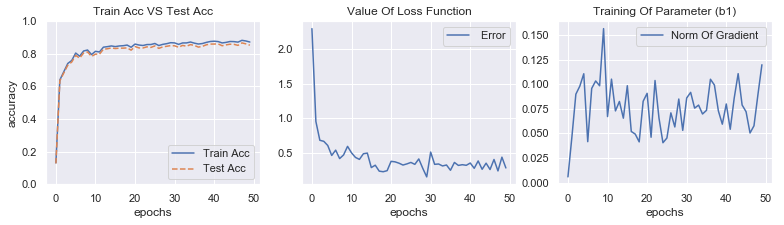

In [0]:
x = np.arange(len(train_acc_list))
plt.figure(figsize=(13,3))
plt.subplot(1,3,1)
plt.plot(x, train_acc_list, label='Train Acc')
plt.plot(x, test_acc_list, label='Test Acc', linestyle='--')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.title("Train Acc VS Test Acc")
plt.subplot(1,3,2)
plt.plot(x, loss_list, label=" Error")
plt.xlabel("epochs")
plt.legend()
plt.title("Value Of Loss Function")
plt.subplot(1,3,3)
x = np.arange(len(grad_list))
plt.plot(x, grad_list, label='Norm Of Gradient ')
plt.xlabel("epochs")
plt.legend()
plt.title("Training Of Parameter (b1)")
plt.savefig("train_neuralnet.png")    

# Pythonによるディープラーニングの実装①

ディープニューラルネットワークを実装します。初めに、基本的な層を作っておきます。

In [0]:
class AddLayer:
    def __init__(self):
        pass
    def forward(self, x,y):
        out = x+y
        return out
    def backward(self, dout):
        dx = dout * 1
        dy = dout *1

In [0]:
class Affine:
    def __init__(self, W, b):
        self.W=W
        self.b=b
        self.x=None
        self.dW=None
        self.db=None
        
    def forward(self ,x):
        self.x = x
        out =np.dot(x, self.W) + self.b
        return out
    def backward(self, dout):
        dx = np.dot(dout, self.W.T)
        self.dW = np.dot(self.x.T , dout)
        self.db = np.sum(dout, axis=0)
        return dx

In [0]:
class SoftmaxWithLoss:
    def __init__(self):
        self.loss = None
        self.y = None
        self.x = None
        
    def forward(self, x, t):
        self.t =t 
        self.y=softmax(x)
        self.loss = cross_entropy_error(self.y, self.t)
        return self.loss
    
    def backward(self, dout=1):
        batch_size= self.t.shape[0]
        dx = (self.y -self.t)/batch_size
        
        return dx

In [0]:
class Relu:
    def __init__(self):
        self.mask=None
        
    def forward(self,x):
        self.mask = (x<= 0)
        out= x.copy()
        self.out = out
        out[self.mask]=0
        return out

    def backward(self, dout):
        dout[self.mask ] = 0 
        dx = dout    
        return dx

In [0]:
from collections import OrderedDict

好きなノード数を持った層を好きな数追加出来るディープニューラルネットワークのクラスを作ります。

In [0]:
class Sequential:

    def __init__(self, input_size, hidden_size, output_size, weight_init_std = 0.01):
        # 重みの初期化
        self.n = len(hidden_size)
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size[0])
        self.params['b1'] = np.zeros(hidden_size[0])
        for i in np.arange(start=2, stop = self.n +1  ) :         
            self.params['W'+str(i)] = weight_init_std * np.random.randn(hidden_size[i-2], hidden_size[i-1])
            self.params['b'+str(i)] = np.zeros(hidden_size[i-1])
        self.params['W'+str(self.n+1)] = weight_init_std * np.random.randn(hidden_size[self.n -1 ], output_size) 
        self.params['b'+str(self.n+1)] = np.zeros(output_size)

        # レイヤの生成
        self.layers = OrderedDict()
        for i in np.arange(start = 1 , stop= self.n +1 ):
            self.layers['Affine'+str(i)] = Affine(self.params['W'+str(i)], self.params['b'+str(i)])
            self.layers['Relu'+str(i)] = Relu()
             
        self.layers['Affine'+str(self.n +1 )] = Affine(self.params['W'+str(self.n +1 )], self.params['b'+str(self.n +1 )])
        self.lastLayer = SoftmaxWithLoss()
        
    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)
        
        return x
        
    # x:入力データ, t:教師データ
    def loss(self, x, t):
        y = self.predict(x)
        return self.lastLayer.forward(y, t)
    
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        if t.ndim != 1 : t = np.argmax(t, axis=1)
        
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy
        
    # x:入力データ, t:教師データ        
    def gradient(self, x, t):
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.lastLayer.backward(dout)
        
        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 設定
        grads = {}
        for i in np.arange(start = 1 , stop = self.n +2):
            grads['W'+str(i)], grads['b'+str(i)] = self.layers['Affine'+str(i)].dW, self.layers['Affine'+str(i)].db

        return grads


学習させます。

In [0]:
network =Sequential(input_size=784, hidden_size=[128,128] , output_size=10)
train_size = train_images.shape[0]
batch_size = 1000
iter_num = 10000
learning_rate =0.1

loss_list = []
train_acc_list = []
test_acc_list = []
grad_list = []
iter_per_epoch = 100

for i in np.arange(iter_num):
    batch_mask = np.random.choice(train_size , batch_size)
    x_batch = train_images[batch_mask]
    t_batch = train_labels[batch_mask]
    grad = network.gradient(x_batch, t_batch)
    for key in network.params.keys():
        network.params[key] -= learning_rate * grad[key]    

    if i % iter_per_epoch == 0:    
        loss = network.loss(x_batch, t_batch)
        loss_list.append(loss)
        train_acc = network.accuracy(train_images, train_labels)
        test_acc = network.accuracy(test_images, test_labels)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print("train acc, test acc | " + str(train_acc) + ", " + str(test_acc))
print("Finish Caluculation")


train acc, test acc | 0.08151666666666667, 0.0814
train acc, test acc | 0.2788833333333333, 0.275
train acc, test acc | 0.43146666666666667, 0.4307
train acc, test acc | 0.62185, 0.6149
train acc, test acc | 0.6752, 0.6719
train acc, test acc | 0.6934, 0.6886
train acc, test acc | 0.70785, 0.6993
train acc, test acc | 0.7571166666666667, 0.7445
train acc, test acc | 0.7664166666666666, 0.754
train acc, test acc | 0.79255, 0.7839
train acc, test acc | 0.815, 0.801
train acc, test acc | 0.80195, 0.7933
train acc, test acc | 0.8219666666666666, 0.811
train acc, test acc | 0.8217833333333333, 0.8089
train acc, test acc | 0.8157333333333333, 0.8037
train acc, test acc | 0.84125, 0.8292
train acc, test acc | 0.8205333333333333, 0.8079
train acc, test acc | 0.8456666666666667, 0.8303
train acc, test acc | 0.8529833333333333, 0.8376
train acc, test acc | 0.84505, 0.8286
train acc, test acc | 0.85345, 0.8394
train acc, test acc | 0.8561666666666666, 0.8427
train acc, test acc | 0.85838333333333

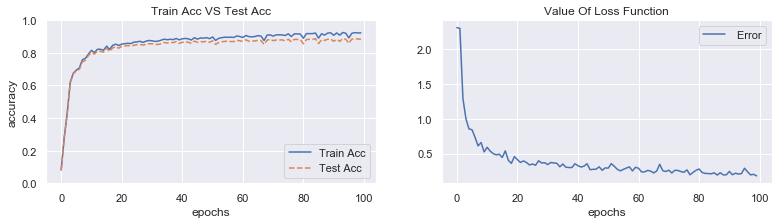

In [0]:
x = np.arange(len(train_acc_list))
plt.figure(figsize=(13,3))
plt.subplot(1,2,1)
plt.plot(x, train_acc_list, label='Train Acc')
plt.plot(x, test_acc_list, label='Test Acc', linestyle='--')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.title("Train Acc VS Test Acc")
plt.subplot(1,2,2)
plt.plot(x, loss_list, label=" Error")
plt.xlabel("epochs")
plt.legend()
plt.title("Value Of Loss Function")
plt.savefig("deep_neural.png")

# Pythonによるディープラーニングの実装➁

畳み込みの実装です。畳み込み層では、画像の持つ幾何学的な性質が保持されることを目で確かめるのが目標です。

In [0]:
import numpy as np
import matplotlib.pyplot as plt

In [0]:
def im2col(input_data, filter_h, filter_w, stride=1, pad=0):
    """

    Parameters
    ----------
    input_data : (データ数, チャンネル, 高さ, 幅)の4次元配列からなる入力データ
    filter_h : フィルターの高さ
    filter_w : フィルターの幅
    stride : ストライド
    pad : パディング

    Returns
    -------
    col : 2次元配列
    """
    N, C, H, W = input_data.shape #データの形状
    out_h = (H + 2*pad - filter_h)//stride + 1 #出力の縦
    out_w = (W + 2*pad - filter_w)//stride + 1 #出力の横

    img = np.pad(input_data, [(0,0), (0,0), (pad, pad), (pad, pad)], 'constant') #必要ならパディング
    col = np.zeros((N, C, filter_h, filter_w, out_h, out_w)) #答えが入ってくる行列の準備, 出力の大きさも入れておく

    for y in range(filter_h):
        y_max = y + stride*out_h 
        for x in range(filter_w):
            x_max = x + stride*out_w
            col[:, :, y, x, :, :] = img[:, :, y:y_max:stride, x:x_max:stride] #ストライド毎にデータを区切る

    col = col.transpose(0, 4, 5, 1, 2, 3).reshape(N*out_h*out_w, -1) #出力の大きさ*(入力データの数)の行列に変換
    return col

In [0]:
class Convolution:
    def __init__(self, W, b, stride=1, pad=0):
        #W:入力画像 , b:バイアス
        self.W = W
        self.b = b
        self.stride = stride
        self.pad = pad

    def forward(self, x):
        FN, C, FH, FW = self.W.shape
        N, C, H, W = x.shape
        out_h = 1 + int((H + 2*self.pad - FH) / self.stride) #出力縦
        out_w = 1 + int((W + 2*self.pad - FW) / self.stride)  #出力横

        col = im2col(x, FH, FW, self.stride, self.pad)
        col_W = self.W.reshape(FN, -1).T

        out = np.dot(col, col_W) + self.b
        out = out.reshape(N, out_h, out_w, -1).transpose(0, 3, 1, 2) #(N,FN, OH,OW ) に整形

        return out

In [0]:
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

In [0]:
train_images = train_images/255.0

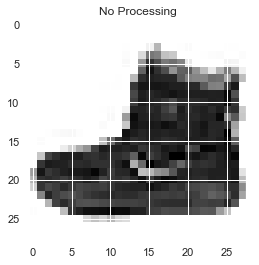

In [0]:
plt.imshow(train_images[0],cmap=plt.cm.binary)
plt.title("No Processing")
#plt.savefig("nopro.png")

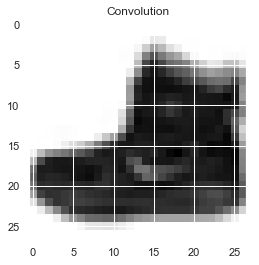

In [0]:
cov=Convolution(W=W, b=b)
x=train_images[0].reshape(1,1,28,28)
plt.imshow(np.sum(cov.forward(x)[0], axis=0 ),cmap=plt.cm.binary)
plt.title("Convolution")
#plt.savefig("conv.png")

畳み込み演算では、画像の持つ図形的な性質が保持されます。

In [0]:
x = train_images[0].flatten()

In [0]:
W=np.random.rand(784*784).reshape(784,-1)
b=0

In [0]:
af=Affine(W=W,b=b)

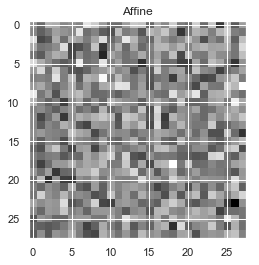

In [0]:
plt.imshow(af.forward(x).reshape(28, 28) , cmap=plt.cm.binary)
plt.title("Affine")
#plt.savefig("aff.png")

アファイン層に通すと、謎の画像になります。

# Pythonによるディープラーニングの実装➂

プーリングの実装です。モデルの汎化性能を高める事が出来ます。
イメージを掴むためにプロットします。

In [0]:
class Pooling:
    def __init__(self, pool_h, pool_w, stride=1, pad=0):
        self.pool_h = pool_h
        self.pool_w = pool_w
        self.stride = stride
        self.pad = pad

    def forward(self, x):
        N, C, H, W = x.shape
        out_h = int(1 + (H - self.pool_h) / self.stride) #畳み込み層と同じ出力結果
        out_w = int(1 + (W - self.pool_w) / self.stride)

        col = im2col(x, self.pool_h, self.pool_w, self.stride, self.pad)
        col = col.reshape(-1, self.pool_h*self.pool_w) #1行に1フィルター分を格納

        arg_max = np.argmax(col, axis=1)
        out = np.max(col, axis=1)
        out = out.reshape(N, out_h, out_w, C).transpose(0, 3, 1, 2)

        return out

Text(0.5, 1.0, 'lena')

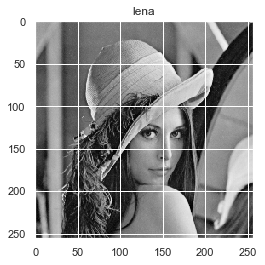

In [0]:
x = plt.imread("lena_gray.png",0 )
plt.imshow(x, cmap="gray")
plt.title("lena")

In [0]:
pool = Pooling(pool_h= 10, pool_w= 10 , stride=1)

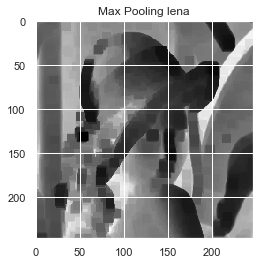

In [0]:
x=x.reshape(1,1,256, 256)
plt.imshow(pool.forward(x).reshape(247,247), cmap="binary")
plt.title("Max Pooling lena")
#plt.savefig("max_pooling_lena.png")